In [1]:
#2020-11-10 21:40:59.053278
%load_ext metapack_jupyter.magic

In [2]:
CACHE_DIR='/Users/eric/Library/Application Support/metapack/'
RESOURCE_NAME='beat_demographics'
RESOLVED_URL='file:///Users/eric/proj/data-projects/metatab-packages/sandiego/sandiego.gov/sandiego.gov-police_regions/notebooks/BeatPopulations.ipynb#beat_demographics'
WORKING_DIR='/Users/eric/proj/data-projects/metatab-packages/sandiego/sandiego.gov/sandiego.gov-police_regions'
METATAB_DOC='metapack+file:///Users/eric/proj/data-projects/metatab-packages/sandiego/sandiego.gov/sandiego.gov-police_regions/metadata.csv'
METATAB_WORKING_DIR='/Users/eric/proj/data-projects/metatab-packages/sandiego/sandiego.gov/sandiego.gov-police_regions'
METATAB_PACKAGE='metapack+file:///Users/eric/proj/data-projects/metatab-packages/sandiego/sandiego.gov/sandiego.gov-police_regions/'

In [3]:
METAPACK_BUILDING=True

# Beat Populations

Link census tract populations, total and by race, into police beats. Attributes population from tracts to beats by the areas of the overlaps. The basic procedure is to find the overlaps between beats and Census tracts, then addign a portion of the population of the tract to the beat, based on the raio of the size of overlap to the size of the tract. 

In [4]:
import seaborn as sns
import metapack as mp
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')


In [5]:
pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
pkg

# San Diego Police Regions and Demographics
`sandiego.gov-police_regions-5` Last Update: 2020-11-11T05:40:58

_Boundary shapes for San Diego neighborhoods, beats and divisions, with ACS estimates for populations, by race._


## Documentation Links

* [Police Divisions Repository Page](https://data.sandiego.gov/datasets/pd-divisions/) Data repository page that links to original files.

 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [pd_beats](data/pd_beats.csv)**. Police beats
* ** [pd_divisions](data/pd_divisions.csv)**. Police Divisions
* ** [pd_neighborhoods](data/pd_neighborhoods.csv)**. Police Neighborhoods
* ** [beat_demographics](notebooks/BeatPopulations.ipynb#beat_demographics)**. Counts of people in the beat, by race.

## References
<ul><li> <strong>tracts</string>, <em>metapack+http://library.metatab.org/sandiegodata.org-communities-2018-7.csv#tracts</em>. Census tracts from 2016 5 year ACS, for San Diego county</li><li> <strong>race</string>, <em>census://2016/5/CA/140/B03002</em>. Race, by tract, in San Diego county</li><ul>

/Users/eric/opt/anaconda3/envs/data/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.
/Users/eric/opt/anaconda3/envs/data/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/Users/eric/opt/anaconda3/envs/data/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


TypeError: 'Polygon' object is not subscriptable

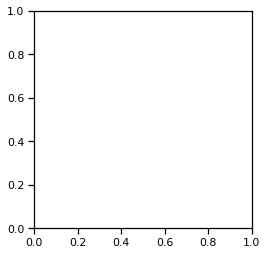

In [6]:
# Convert to EPSG:26911, ( A randomly selected UTM Zone 11N CRS) so area calculations 
# will be in square meters, rather than square degrees
beats = pkg.resource('pd_beats').geoframe().to_crs(26911)

# There are  beats that are way off in east county. Get rid of them.
rightmost_centroid = beats.centroid.x.sort_values(ascending=False).iloc[:6].max()

beats = beats[beats.centroid.x <rightmost_centroid]




# It looks like the dataset has multiple rows per beat, one feature per row. We need
# it to have one row per beat, with multiple features combined together. 
beats = beats.dissolve(by='beat').reset_index()

#  Add the area
beats['beat_area'] = beats.area / 1_000_000

beats.plot()


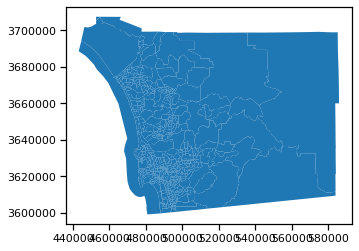

In [4]:
tracts = pkg.reference('tracts').geoframe()

tracts = tracts.to_crs({'init': 'epsg:26911'})

#  Add the area
tracts['tract_area'] = tracts.area / 1_000_000


tracts.plot()

In [15]:
from rowgenerators import dataframe, parse_app_url
t = dataframe('census://CA/140/B03002')

In [6]:
# White, black, asian, etc are all non hispanic. 
col_map = {
    'b03002_001':'total',
    'b03002_003':'white',
    'b03002_004':'black',
    'b03002_005':'aian',
    'b03002_006':'asian',
    'b03002_007':'nhopi', 
    'b03002_012':'hisp'
    
}

for k,v in list(col_map.items()):
    col_map[k+'_m90'] = col_map[k]+'_m90'
    
race_tracts = t[t.county=='073'].rename(columns=col_map).reset_index().rename(columns={'GEOID':'geoid'})

In [7]:
race_tracts = race_tracts[['geoid', 'total', 'white', 'black', 'aian', 'asian', 'nhopi', 'hisp']]
race_tracts.titles.head().T

,0,1,2,3,4
GEOID,14000US06073000100,14000US06073000201,14000US06073000202,14000US06073000300,14000US06073000400
total,2863,2056,5021,5174,3717
white,2447,1795,3696,3892,2253
black,0,10,47,187,85
aian,0,9,46,0,0
asian,81,77,404,230,499
nhopi,0,0,0,7,0
hisp,253,112,662,660,781


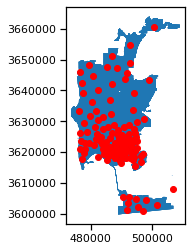

In [8]:
t = gpd.sjoin(beats, tracts)

ax = t.plot()
beats.centroid.plot(ax=ax, color='red')

t = t[['geoid', 'beat']].drop_duplicates()\
    .merge(tracts[['geoid','geometry', 'tract_area']],on='geoid')\
    .merge(beats[['beat','geometry', 'beat_area']],on='beat')


In [9]:
intr = gpd.overlay(beats, tracts, how='intersection')[['beat','geoid','geometry']]

intr['intr_area'] = (intr.geometry.area/1_000_000.0).astype(float)

# Get rid of really small intersections
intr = intr[intr.intr_area >= .01] 

merged = intr[['beat','geoid', 'intr_area']]\
    .merge(tracts[['geoid', 'tract_area']],on='geoid')\
    .merge(beats[['beat', 'beat_area']],on='beat')\
    .merge(race_tracts, on='geoid')

merged = merged.drop_duplicates(subset=['beat','geoid'])

merged['tract_overlap_proportion'] = merged.intr_area/merged.tract_area
merged['beat_overlap_proportion'] = merged.intr_area/merged.beat_area

# The intersection areas must be smaller than both of the areas being intersected
assert(not any(merged.intr_area > merged.beat_area))
assert(not any(merged.intr_area > merged.tract_area))

# Check that all of the areas of the beats are accounted for
assert(all(merged.groupby('beat').beat_overlap_proportion.sum().round(1) == 1))

merged['total'] = merged.total * merged.tract_overlap_proportion
merged['white'] = merged.white * merged.tract_overlap_proportion
merged['asian'] = merged.asian * merged.tract_overlap_proportion
merged['black'] = merged.black * merged.tract_overlap_proportion
merged['aian']  = merged.aian * merged.tract_overlap_proportion
merged['hisp']  = merged.hisp * merged.tract_overlap_proportion
merged['nhopi']  = merged.nhopi * merged.tract_overlap_proportion

merged.head().T


,0,1,2,3,4
beat,0,721,0,0,511
geoid,14000US06073021900,14000US06073021900,14000US06073021600,14000US06073003800,14000US06073003800
intr_area,0.183666,0.0228637,0.645752,0.0366767,1.77264
tract_area,10.6162,10.6162,15.2322,1.82267,1.82267
beat_area,18.2475,7.63003,18.2475,18.2475,6.80108
total,98.336,12.2414,140.112,132.889,6422.74
white,30.7603,3.8292,93.8603,64.8749,3135.51
black,15.1206,1.8823,5.6384,28.8959,1396.59
aian,1.33214,0.165832,0.084788,1.14698,55.4355
asian,11.4702,1.42787,5.17207,10.7052,517.398


In [10]:
beat_demographics = merged.groupby('beat').sum()[['total', 'white', 'black', 'aian', 'asian', 'nhopi', 'hisp']].round()

In [ ]:
%mt_materialize beat_demographics '/Users/eric/Library/Application Support/metapack/_materialized_data/sandiego.gov-police_regions-5' 

In [ ]:

%mt_materialize_all '/Users/eric/Library/Application Support/metapack/_materialized_data/sandiego.gov-police_regions-5'


In [ ]:

%mt_show_metatab



In [ ]:

%mt_show_libdirs

